In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, GRU, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [13]:
# Load the dataset
file_path = 'caps_fin - clean.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

                                 resto_name  \
0          Soon Fatt Chinese Restaurant JGC   
1                Sambal Bakar Indonesia JGC   
2           Shu Guo Yin Xiang Kelapa Gading   
3  Layar Seafood Dan Ikan Bakar Sedayu City   
4                      Global Bakery Cakung   

                                             address           area  \
0  Ruko The Boulevard no. 39, Jl. Jkt Garden City...  Jakarta Timur   
1  Ruko Cleon Park Jakarta Garden City, Jl. Jkt G...  Jakarta Timur   
2  Old Shanghai Sedayu City, Unit D2, Cakung Bar....  Jakarta Timur   
3  RT.8/RW.5, Rawa Terate, Cakung, East Jakarta C...  Jakarta Timur   
4  Jl. Tipar Cakung No.2, RT.5/RW.8, Cakung Bar.,...  Jakarta Timur   

   opening_hours closing_hours  start_price  end_price  average_price  rating  \
0           10.0         22.00        50000    75000.0          62500     4.7   
1           10.0         24.00        25000    50000.0          37500     4.4   
2           10.0         23.00        50000   1

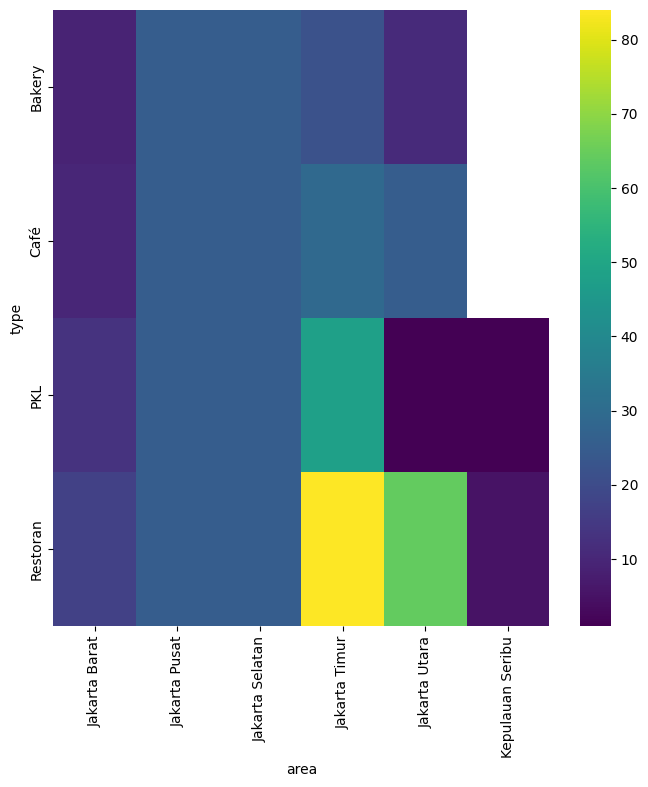

In [14]:
# Plotting various visualizations
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['type'].value_counts()
    for x_label, grp in data.groupby('area')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('area')
_ = plt.ylabel('type')
plt.show()

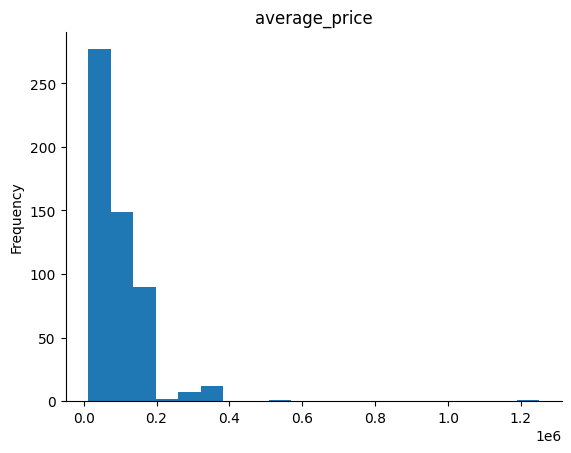

In [15]:
data['average_price'].plot(kind='hist', bins=20, title='average_price')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

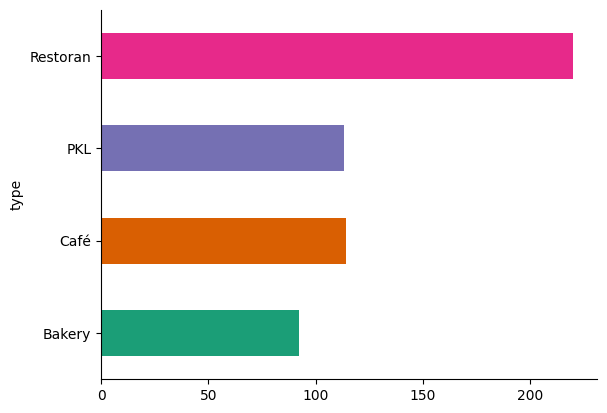

In [16]:
data.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

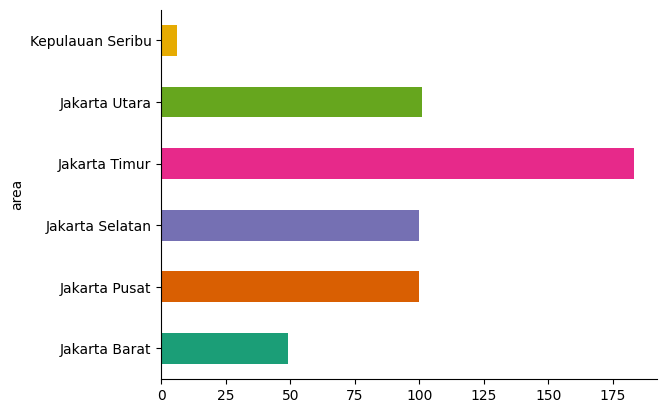

In [17]:
data.groupby('area').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

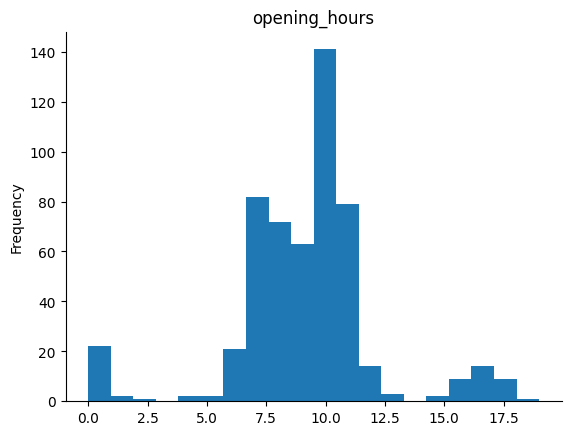

In [18]:
data['opening_hours'].plot(kind='hist', bins=20, title='opening_hours')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

In [19]:
# Checking for missing values
print(data.isnull().sum())

# Dropping rows with missing values
data_cleaned = data.dropna()

# Normalizing text data: converting to lowercase and removing special characters
data_cleaned['resto_name'] = data_cleaned['resto_name'].str.lower().str.replace('[^a-zA-Z0-9 ]', '', regex=True)
data_cleaned['address'] = data_cleaned['address'].str.lower().str.replace('[^a-zA-Z0-9 ]', '', regex=True)
data_cleaned['area'] = data_cleaned['area'].str.lower().str.replace('[^a-zA-Z0-9 ]', '', regex=True)
data_cleaned['type'] = data_cleaned['type'].str.lower().str.replace('[^a-zA-Z0-9 ]', '', regex=True)

# Display the cleaned data
print(data_cleaned.head())

resto_name       0
address          0
area             0
opening_hours    0
closing_hours    0
start_price      0
end_price        1
average_price    0
rating           0
type             0
review           1
dtype: int64
                                 resto_name  \
0          soon fatt chinese restaurant jgc   
1                sambal bakar indonesia jgc   
2           shu guo yin xiang kelapa gading   
3  layar seafood dan ikan bakar sedayu city   
4                      global bakery cakung   

                                             address           area  \
0  ruko the boulevard no 39 jl jkt garden city bo...  jakarta timur   
1  ruko cleon park jakarta garden city jl jkt gar...  jakarta timur   
2  old shanghai sedayu city unit d2 cakung bar ke...  jakarta timur   
3  rt8rw5 rawa terate cakung east jakarta city ja...  jakarta timur   
4  jl tipar cakung no2 rt5rw8 cakung bar kec caku...  jakarta timur   

   opening_hours closing_hours  start_price  end_price  average_pric

<ipython-input-19-b90b5d38cce4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['resto_name'] = data_cleaned['resto_name'].str.lower().str.replace('[^a-zA-Z0-9 ]', '', regex=True)
<ipython-input-19-b90b5d38cce4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['address'] = data_cleaned['address'].str.lower().str.replace('[^a-zA-Z0-9 ]', '', regex=True)
<ipython-input-19-b90b5d38cce4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [20]:
# Concatenating relevant text features for the content-based filtering
data_cleaned['text'] = data_cleaned['resto_name'] + ' ' + data_cleaned['address'] + ' ' + data_cleaned['area'] + ' ' + data_cleaned['type']


<ipython-input-20-f2fcd7f882bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['text'] = data_cleaned['resto_name'] + ' ' + data_cleaned['address'] + ' ' + data_cleaned['area'] + ' ' + data_cleaned['type']


In [21]:
# Tokenizing the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_cleaned['text'])
sequences = tokenizer.texts_to_sequences(data_cleaned['text'])
word_index = tokenizer.word_index

In [22]:
# Padding the sequences
max_sequence_length = 100
data_padded = pad_sequences(sequences, maxlen=max_sequence_length)

In [23]:
# Converting ratings to categories
labels = data_cleaned['rating'].astype(int).values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = to_categorical(labels)

In [24]:
# Splitting the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

In [25]:
# Defining the model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(word_index) + 1, 128, input_length=max_sequence_length)(input_layer)
x = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
x = Dropout(0.5)(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [26]:
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [28]:
# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 14s 736ms/step - loss: 0.7420 - accuracy: 0.9114 - val_loss: 0.3404 - val_accuracy: 0.9630
Epoch 2/100
7/7 [==============================] - 3s 412ms/step - loss: 0.3770 - accuracy: 0.9394 - val_loss: 0.1799 - val_accuracy: 0.9630
Epoch 3/100
7/7 [==============================] - 4s 564ms/step - loss: 0.2861 - accuracy: 0.9394 - val_loss: 0.2701 - val_accuracy: 0.9630
Epoch 4/100
7/7 [==============================] - 4s 582ms/step - loss: 0.2937 - accuracy: 0.9394 - val_loss: 0.3141 - val_accuracy: 0.9630
Epoch 5/100
7/7 [==============================] - 3s 441ms/step - loss: 0.2726 - accuracy: 0.9394 - val_loss: 0.2191 - val_accuracy: 0.9630
Epoch 6/100
7/7 [==============================] - 3s 421ms/step - loss: 0.2896 - accuracy: 0.9394 - val_loss: 0.1948 - val_accuracy: 0.9630
Epoch 7/100
7/7 [==============================] - 4s 590ms/step - loss: 0.2778 - accuracy: 0.9394 - val_loss: 0.2404 - val_accuracy: 0.9630
Epoch 8/100


In [29]:
# Evaluating the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)

# Displaying the evaluation results
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 [==============================] - 0s 50ms/step - loss: 0.1209 - accuracy: 0.9630
Validation Loss: 0.12086658179759979
Validation Accuracy: 0.9629629850387573


In [30]:
# Saving the model to an H5 file
model.save('bitewise1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
